Author: Corentin Llorca

# Regression on the Ames housing dataset. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.simplefilter('ignore')

## Loading the data

We start by loading the data. We make sure to only treat missing values as NaN. Moreover, we also have to "force" some categorical features to be treated as such - some of them are treated as continuous because they contain numbers. Please note that most of the features listed as "discrete" by the description are kept as non-categorical features here: we only force those listed as "nominal" and "ordinal", and the discrete features that wouldn't make sense as continuous.

In [2]:
#A list of the variables we want to "enforce" as categorical
cat = ['MS SubClass', 'Overall Qual', 'Overall Cond', 'Mo Sold']
catd = {}
for e in cat: 
    catd[e]='object'

df = pd.read_excel("data/reg.xls", dtype=catd,
                   na_values=[''], keep_default_na=False)

The column 'MS SubClass' is, in a pretty straightforward way, a nominal variable in which the category names are number, so it needs to be forced as categorical. 

The columns 'Overall Qual' and 'Overall Cond' actually pose a real problem. They are categorical, but ordered (ordinal), so keeping them as integers instead of objects would actually make sense, because we'd at least keep the order. Here, we completely lose it. However, we gain consistency in regards to other "ratings" columns such as 'Exter Qual' and 'Exter Cond' which are treated as unordered categoricals by pandas anyway. What we would really need to do is to take all the ordinal features and tell pandas the order for each one of them, but that would be too time-consuming. 

The column 'Mo Sold' corresponds to a "discrete" feature that wouldn't make sense as a continuous feature, because the ordering of the month doesn't matter. All the other discrete features (years, number of rooms...) are judged to make sense as a categorical because ordering matters in their case - and again, we don't want to spend all our time forcing a custom order on each of them. 

We drop the "order" column, because we don't want it to have an influence in predictions. The pandas dataframe is already automatically indexed, so the column serves no purpose. For the same reasons, we drop the "PID" (parcel ID) feature, because it has no real use in prediction.

In [3]:
df.drop(columns=['Order', 'PID'], inplace=True)

## Visualizing the features

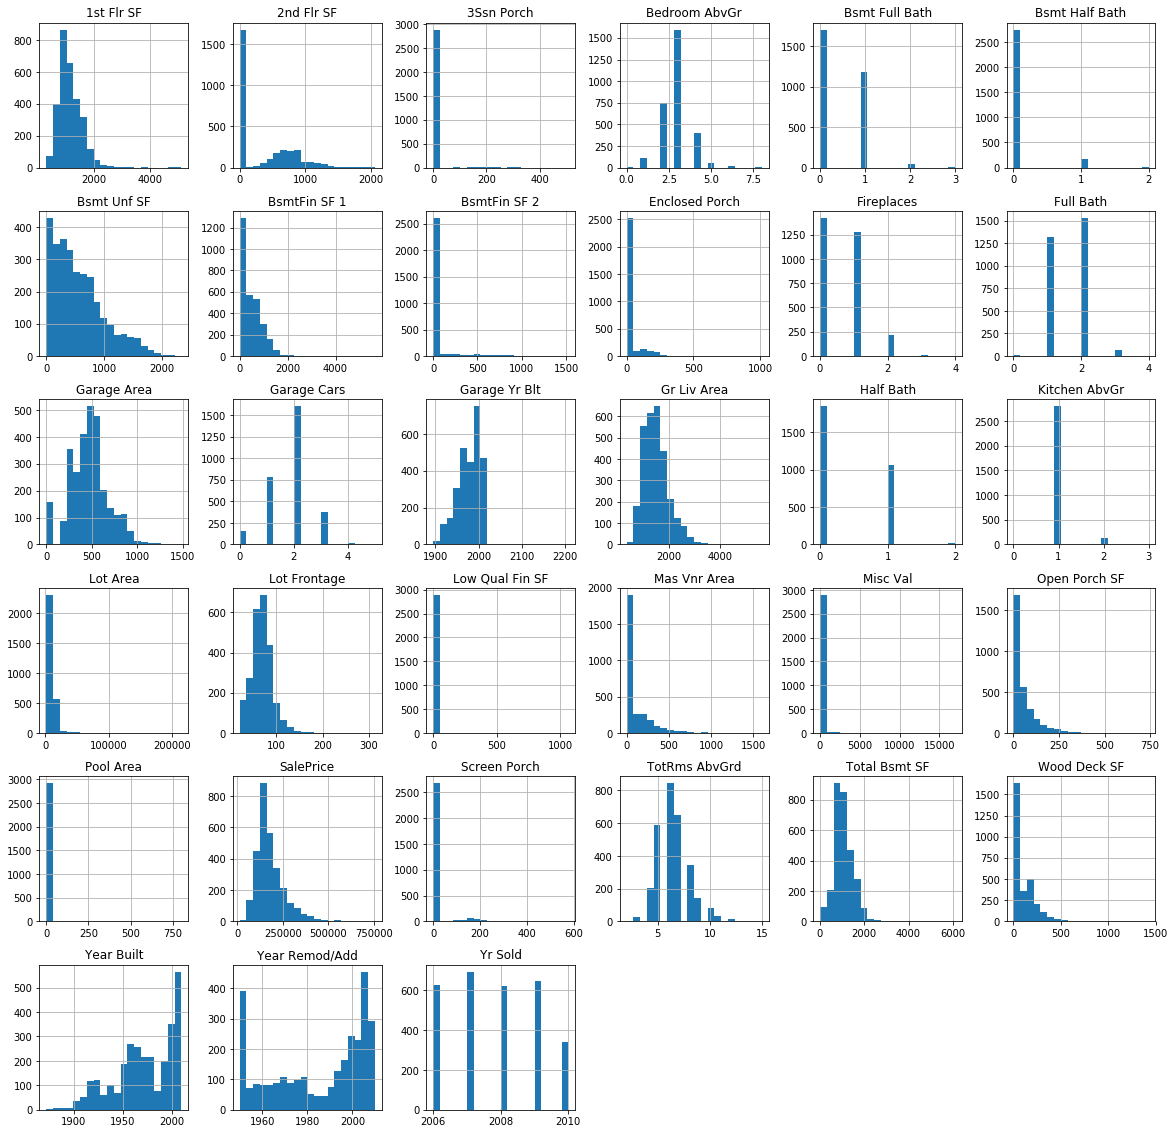

In [4]:
_ = df.hist(figsize = (20, 20), bins=20)

We notice that some histograms clearly show discrete variables, which we were expecting since we kept those as continuous when importing the data. More importantly, we can see that a lot of variables have a very high concentration of values near zero, which either indicates that there are some outliers that are "squeezing" the representation of the data into a single bin near zero, or that the data has a lot of missing values that are actually imputed as zero instead of missing or NaN. This is probably the case in variables such as "2nd Flr SF" (second floor square feet) as not all houses have second floors: for those houses, instead of there being a missing value, the value is zero. In both cases (outliers and data inputed as 0), the data requires special treatment.

## Visualizing the features against the target

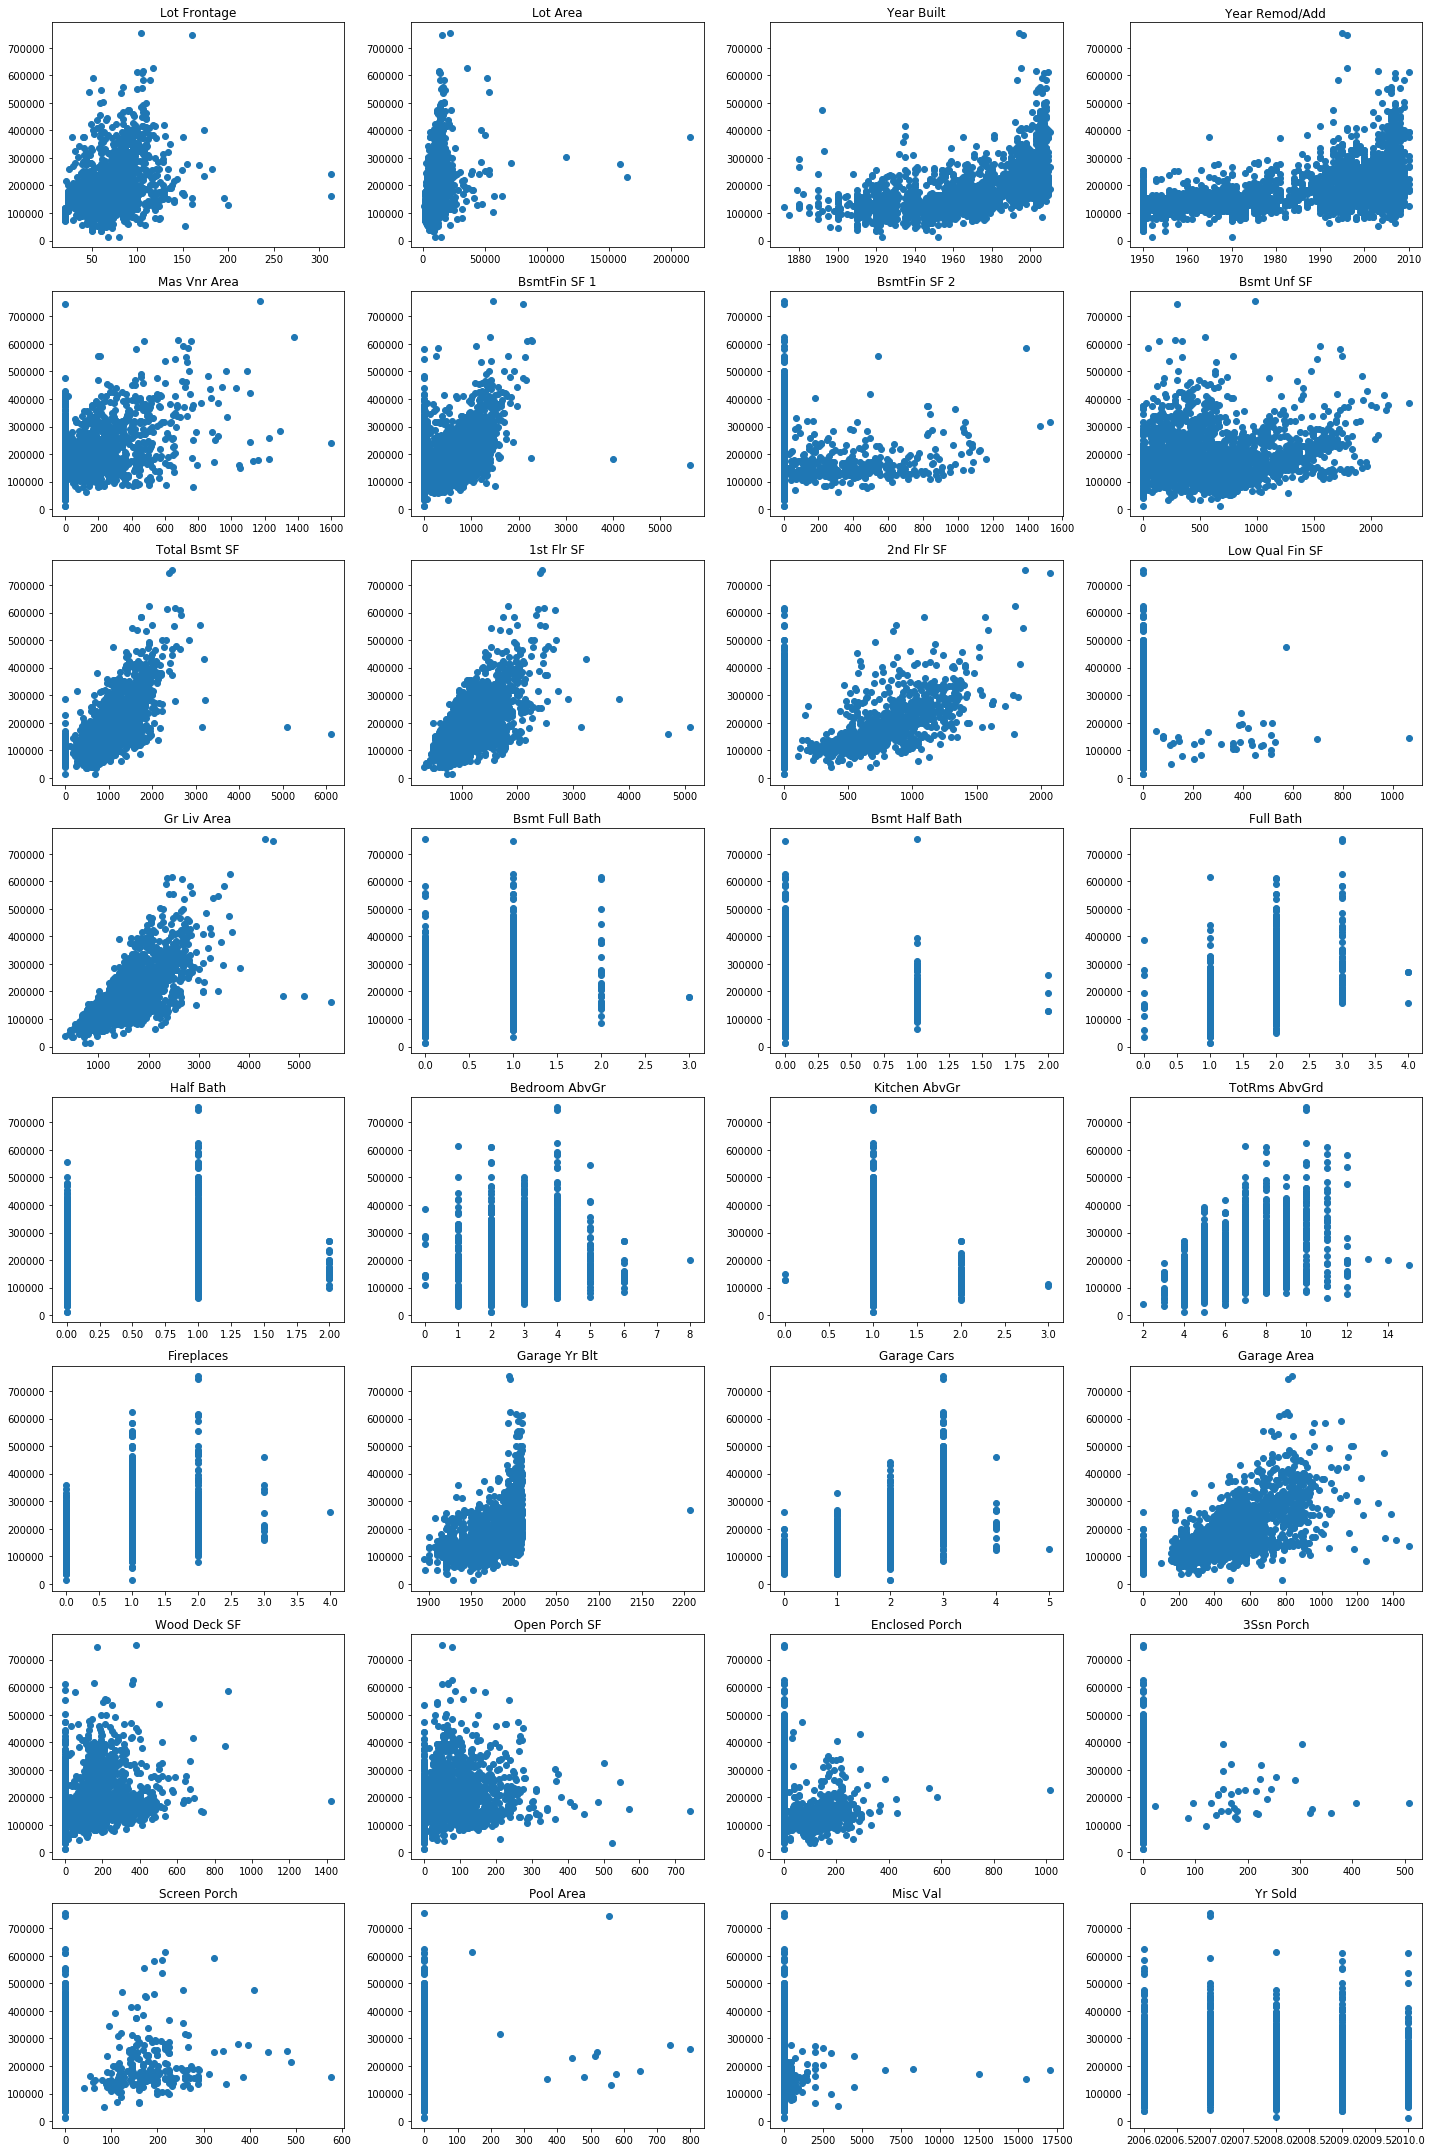

In [5]:
fig, ax = plt.subplots(8, 4, figsize = (20, 30))
# Columns with continuous features only
cols_cont = df.columns[df.dtypes != object].tolist()
for i in range(len(cols_cont)): 
    if (cols_cont[i] != 'SalePrice'):
        ax[i//4][i % 4].scatter(df[cols_cont[i]], df['SalePrice'])
        ax[i//4][i % 4].set_title(cols_cont[i])
plt.tight_layout()

Again, we see that some features are clearly discrete, which we again expected. Moreover, a lot of features (usually regarding parts of houses that aren't present in every house) show a vertical line on zero, meaning that a lot of values are imputed as zero. We also see some clear outliers such as the one in "Garage Yr Built" (year 2200). Finally, for some variables, we actually do see a pretty clear correlation with the sale price - most of them having to do with the house's surface area.

## Splitting training and test set

Let's first separate features and target.

In [6]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

Now, we do the train/test split

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

We also notice some missing values in some categorical variables. We assign the category 'missing' to those missing values.

In [8]:
Xt_cols_cat = X_train.columns[X_train.dtypes == object].tolist()
dict_missing = {i: 'Missing' for i in Xt_cols_cat}
X_train.fillna(dict_missing, inplace=True)

## Which features have the highest correlation with the target? 

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
enc = OneHotEncoder(categories="auto")
from sklearn.model_selection import cross_val_score
R2s = []
for i in Xt_cols_cat:
    Xtemp = enc.fit_transform(X_train[[i]])
    R2s.append(np.mean(cross_val_score(lr, Xtemp, y_train, cv=10)))

Here are the features with the best $R^2$ score:

In [10]:
top3 = np.array(Xt_cols_cat)[np.array(R2s).argsort()[-3:][::-1]]
top3.tolist()

['Overall Qual', 'Neighborhood', 'Exter Qual']

And here is their relationship with the target:

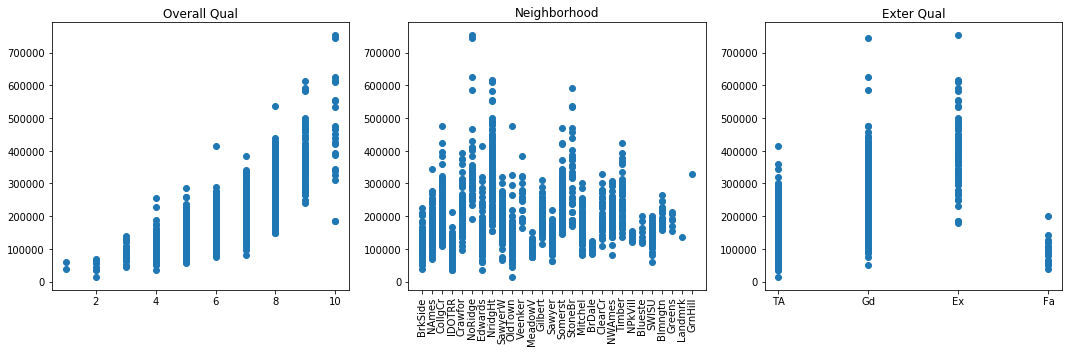

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for i in range(3): 
    ax[i].scatter(X_train[top3[i]], y_train)
    if i==1:
        plt.sca(ax[1])
        plt.xticks(rotation=90)
    ax[i].set_title(top3[i])
plt.tight_layout()

## Imputing missing values and training some models

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

We're using ColumnTransformer and pipeline to encode categorical variables. Since we need to treat the missing values in the continuous variables, we add a "Simple Imputer" step to the pipelines. We then evaluate Linear
Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default
parameters.

In [13]:
si = SimpleImputer(strategy="mean")
ohe = OneHotEncoder(categories="auto", handle_unknown = 'ignore')
lr = LinearRegression(fit_intercept=True)
ridge = Ridge()
lasso = Lasso(max_iter=5000)
en = ElasticNet(max_iter=5000)
Xt_cat = X_train.dtypes == object

prep = ColumnTransformer([('imputer', si, ~Xt_cat), ("one-hot encoding", ohe, Xt_cat)])

pipe_ols = Pipeline([('preprocessing', prep), ('lr', lr)])
pipe_ridge = Pipeline([('preprocessing', prep), ('ridge', ridge)])
pipe_lasso = Pipeline([('preprocessing', prep), ('lasso', lasso)])
pipe_en = Pipeline([('preprocessing', prep), ('en', en)])

s_ols = np.mean(cross_val_score(pipe_ols, X_train, y_train, cv=10))
print("Score for OLS: " + str(s_ols))

s_ridge = np.mean(cross_val_score(pipe_ridge, X_train, y_train, cv=10))
print("Score for Ridge: " + str(s_ridge))

s_lasso = np.mean(cross_val_score(pipe_lasso, X_train, y_train, cv=10))
print("Score for Lasso: " + str(s_lasso))

s_en = np.mean(cross_val_score(pipe_en, X_train, y_train, cv=10))
print("Score for Elastic Net: " + str(s_en))

Score for OLS: 0.8696205060299432
Score for Ridge: 0.7086332361865224
Score for Lasso: 0.8730309801176089
Score for Elastic Net: 0.8437967476723912


Let's now try the same steps, but with an added Standard Scaler in the preprocessing.

In [14]:
ssc = StandardScaler()
pipe_pre_cont = Pipeline([('imputer', si), ('scaler', ssc)]) 
#Making sure imputing is done before scaling
prep = ColumnTransformer([('missing_scaling', pipe_pre_cont, ~Xt_cat),('one-hot encoding', ohe, Xt_cat)])

pipe_ols = Pipeline([('preprocessing', prep), ('lr', lr)])
pipe_ridge = Pipeline([('preprocessing', prep), ('ridge', ridge)])
pipe_lasso = Pipeline([('preprocessing', prep), ('lasso', lasso)])
pipe_en = Pipeline([('preprocessing', prep), ('en', en)])

s_ols = np.mean(cross_val_score(pipe_ols, X_train, y_train, cv=10))
print("Score for OLS with Standard Scaling: " + str(s_ols))

s_ridge = np.mean(cross_val_score(pipe_ridge, X_train, y_train, cv=10))
print("Score for Ridge with Standard Scaling: " + str(s_ridge))

s_lasso = np.mean(cross_val_score(pipe_lasso, X_train, y_train, cv=10))
print("Score for Lasso with Standard Scaling: " + str(s_lasso))

s_en = np.mean(cross_val_score(pipe_en, X_train, y_train, cv=10))
print("Score for Elastic Net with Standard Scaling: " + str(s_en))

Score for OLS with Standard Scaling: 0.8723001923431036
Score for Ridge with Standard Scaling: 0.8778823231127323
Score for Lasso with Standard Scaling: 0.873023594099933
Score for Elastic Net with Standard Scaling: 0.8486953382888878


Scaling the data helps, especially with Ridge regression.

## Tuning the parameters using a grid search

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid_r = {'ridge__alpha': np.logspace(-3, 3, 13)}
param_grid_l = {'lasso__alpha': np.logspace(-3, 0, 13)}
param_grid_en = {'en__alpha': np.logspace(-4, -1, 10),
                 'en__l1_ratio': [0.01, .1, .5, .9, .98, 1]}

grid_r = GridSearchCV(pipe_ridge, param_grid_r, cv=10)
_ = grid_r.fit(X_train, y_train)

grid_l = GridSearchCV(pipe_lasso, param_grid_l, cv=10)
_ = grid_l.fit(X_train, y_train)

grid_en = GridSearchCV(pipe_en, param_grid_en, cv=10)
_ = grid_en.fit(X_train, y_train)

In [16]:
s_ridge3 = grid_r.best_score_
print("Score for Ridge with Standard Scaling and Grid Search CV: " + str(s_ridge3))

s_lasso3 = grid_l.best_score_
print("Score for Lasso with Standard Scaling and Grid Search CV: " + str(s_lasso3))

s_en3 = grid_en.best_score_
print("Score for Elastic Net with Standard Scaling and Grid Search CV: " + str(s_en3))

Score for Ridge with Standard Scaling and Grid Search CV: 0.8786526000817977
Score for Lasso with Standard Scaling and Grid Search CV: 0.8729570125364614
Score for Elastic Net with Standard Scaling and Grid Search CV: 0.8790006281516004


We see that the scores improve slightly for Ridge and Lasso regression. However, the increase for ElasticNet is much more visible, probably because we search across a 2D grid rather than 1D.

Let's now visualize the training and test scores depending on the parameters.

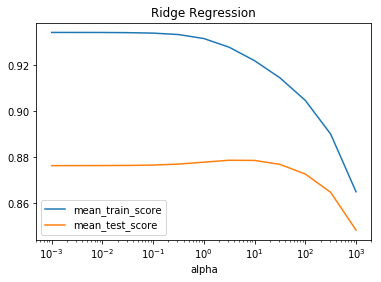

In [17]:
results_r = pd.DataFrame(grid_r.cv_results_)
results_r.plot('param_ridge__alpha', 'mean_train_score')
results_r.plot('param_ridge__alpha', 'mean_test_score', ax=plt.gca())
plt.legend()
plt.xscale("log")
plt.xlabel("alpha")
plt.title("Ridge Regression")
plt.show()

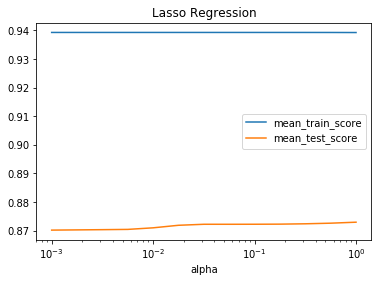

In [18]:
results_l = pd.DataFrame(grid_l.cv_results_)
results_l.plot('param_lasso__alpha', 'mean_train_score')
results_l.plot('param_lasso__alpha', 'mean_test_score', ax=plt.gca())
plt.legend()
plt.xscale("log")
plt.xlabel("alpha")
plt.title("Lasso Regression")
plt.show()

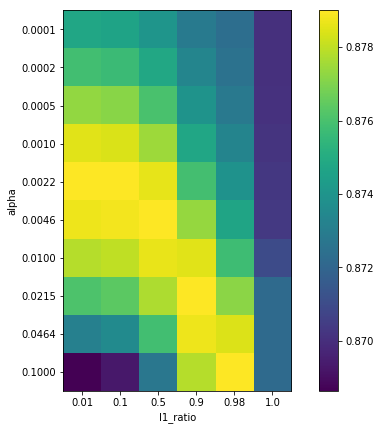

In [19]:
res = pd.pivot_table(pd.DataFrame(grid_en.cv_results_),
                     values='mean_test_score', index='param_en__alpha', 
                     columns='param_en__l1_ratio')
plt.figure(figsize = (10,7))
plt.imshow(res)
plt.colorbar()
alphas = param_grid_en['en__alpha']
l1_ratio = np.array(param_grid_en['en__l1_ratio'])
plt.xlabel("l1_ratio")
plt.ylabel("alpha")
plt.yticks(range(len(alphas)), ["{:.4f}".format(a) for a in alphas])
plt.xticks(range(len(l1_ratio)), l1_ratio);

## Visualizing the top 10 coefficients for all 3 models

We choose to display bar charts of the top 10 features for all 3 models - that is, the features with the largest coefficients in absolute value. We directly use the 'best estimator' attribute from the grid searches. Unfortunately, I haven't found a way to retrieve the corresponding feature names from the ColumnTransformer step of the pipeline. I can access the feature names returned by the 'one hot encoding' steps of the categorical preprocessing pipeline, but I can't access the feature names in the output of the column transformer itself (because it contains pipelines that don't support the get_feature_names() method). 

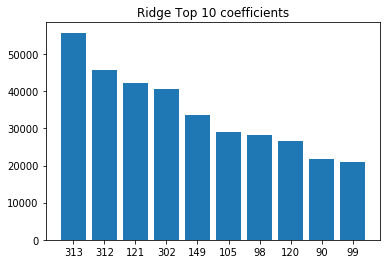

In [20]:
coeffs_ridge = np.abs(grid_r.best_estimator_.named_steps['ridge'].coef_)
top10_ridge = np.argsort(coeffs_ridge)[::-1][:10]
plt.bar([str(i) for i in top10_ridge], coeffs_ridge[top10_ridge])
plt.title("Ridge Top 10 coefficients")
plt.show()

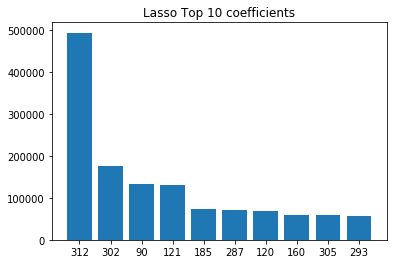

In [21]:
coeffs_lasso = np.abs(grid_l.best_estimator_.named_steps['lasso'].coef_)
top10_lasso = np.argsort(coeffs_lasso)[::-1][:10]
plt.bar([str(i) for i in top10_lasso], coeffs_lasso[top10_lasso])
plt.title("Lasso Top 10 coefficients")
plt.show()

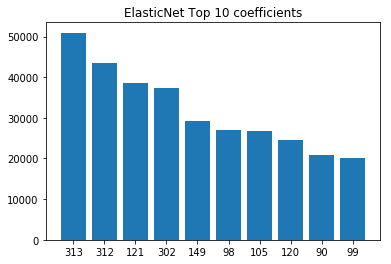

In [22]:
coeffs_en = np.abs(grid_en.best_estimator_.named_steps['en'].coef_)
top10_en = np.argsort(coeffs_en)[::-1][:10]
plt.bar([str(i) for i in top10_en], coeffs_en[top10_en])
plt.title("ElasticNet Top 10 coefficients")
plt.show()

We can see that the models generally agree on which features are important: feature number 312 is top 2 every time, generally followed by 302, 313 or 121. We would really like to know to which features that actually corresponds, but unfortunately we haven't found a way.